In [1]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
import torchvision

from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision.models import ResNet18_Weights, ResNeXt50_32X4D_Weights
import torchvision.transforms as transforms
from PIL import Image
from d2l import torch as d2l

# os.environ["CUDA_VISIBLE_DEVICES"] = "2, 3"

In [2]:
my_seed = 6666  # set a random seed for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(my_seed)
torch.manual_seed(my_seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(my_seed)

# 一、数据

## 数据读取

In [3]:
data_path = "../data/classify-leaves"
train_data = pd.read_csv(os.path.join(data_path, "train.csv"))
test_data = pd.read_csv(os.path.join(data_path, "test.csv"))

train_files = []
test_files = []
labels = []
for file_name, label in train_data.values:
    train_files.append(file_name)
    labels.append(label)
for file_name, in test_data.values:
    test_files.append(file_name)

label2id = {}
id2label = {}
for idx, label in enumerate(set(labels)):
    label2id[label] = idx
    id2label[idx] = label
labels = [label2id[label] for label in labels]

num_samples = len(train_files)
num_train = int(0.9 * num_samples)
val_files, val_labels = train_files[num_train:], labels[num_train:]
train_files, train_labels = train_files[:num_train], labels[:num_train]

## 数据增强

In [4]:
train_tfm = transforms.Compose([
    transforms.Resize((224, 224)),
    # You may add some transforms here.
    transforms.RandomHorizontalFlip(p=0.5),  # 随机水平翻转
    transforms.RandomResizedCrop((224, 224), scale=(0.35, 1.0)),  # 随机裁剪图像
    # transforms.RandomRotation((-180, 180)),  # 随机旋转图像
    transforms.RandomAffine(degrees=(-180, 180), shear=(-30, 30)),  # 图像保持中心不变的随机仿射变换
    transforms.ColorJitter(brightness=(0.5, 1.5), contrast=(0.5, 1.5), saturation=(0.5, 1.5), hue=(-0.1, 0.1)),  # 修改亮度、对比度和饱和度
    # transforms.RandomInvert(0.2),  # 随机反转图像
    # transforms.RandomGrayscale(0.2),  # 随机转换为灰度图像
    # ToTensor() should be the last one of the transforms.
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

test_tfm = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop((224, 224)),  # 中心裁剪
    transforms.RandomResizedCrop((224, 224), scale=(0.5, 1.0)),  # 随机裁剪图像
    transforms.RandomRotation((-180, 180)),  # 随机旋转图像
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

## 数据封装

In [18]:
class LeaveDataset(Dataset):
    def __init__(self, path, file_names, labels=None, transform=None, num_ensemble=1):
        super().__init__()
        self.path = path
        self.file_names = file_names
        self.labels = labels
        self.transform = transform
        self.num_ensemble = num_ensemble

    def __len__(self):
        return len(self.file_names)

    def __getitem__(self, idx):
        image = Image.open(os.path.join(self.path, self.file_names[idx]))
        label = self.labels[idx] if self.labels else -1
        if self.transform:
            if self.num_ensemble > 1 and self.labels is None:
                image = torch.tensor(self.transform(image)
                                     for _ in range(self.num_ensemble))
            else:
                image = self.transform(image)
        return image, label

train_set = LeaveDataset(data_path, train_files, train_labels, transform=train_tfm)
val_set = LeaveDataset(data_path, val_files, val_labels, transform=test_tfm)
test_set = LeaveDataset(data_path, test_files, transform=test_tfm)
train_set[0], val_set[0], test_set[0]

((tensor([[[-2.1179, -2.1179, -2.1179,  ...,  2.2489,  2.2489,  2.2489],
           [-2.1179, -2.1179, -2.1179,  ...,  2.2489,  2.2489,  2.2489],
           [-2.1179, -2.1179, -2.1179,  ...,  2.2489,  2.2489,  2.2489],
           ...,
           [ 2.2489,  2.2489,  2.2489,  ..., -2.1179, -2.1179, -2.1179],
           [ 2.2489,  2.2489,  2.2489,  ..., -2.1179, -2.1179, -2.1179],
           [ 2.2489,  2.2489,  2.2489,  ..., -2.1179, -2.1179, -2.1179]],
  
          [[-2.0357, -2.0357, -2.0357,  ...,  2.4286,  2.4286,  2.4286],
           [-2.0357, -2.0357, -2.0357,  ...,  2.4286,  2.4286,  2.4286],
           [-2.0357, -2.0357, -2.0357,  ...,  2.4286,  2.4286,  2.4286],
           ...,
           [ 2.4286,  2.4286,  2.4286,  ..., -2.0357, -2.0357, -2.0357],
           [ 2.4286,  2.4286,  2.4286,  ..., -2.0357, -2.0357, -2.0357],
           [ 2.4286,  2.4286,  2.4286,  ..., -2.0357, -2.0357, -2.0357]],
  
          [[-1.8044, -1.8044, -1.8044,  ...,  2.6400,  2.6400,  2.6400],
           

In [19]:
batch_size = 256
train_iter = DataLoader(train_set, batch_size, shuffle=True, num_workers=16)
val_iter = DataLoader(val_set, batch_size, shuffle=False, num_workers=16)
test_iter = DataLoader(test_set, batch_size, shuffle=False, num_workers=16)

# 二、模型

## 定义模型

In [7]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride, use_1x1_conv):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, stride, 1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels)
        )
        if use_1x1_conv:
            self.conv3 = nn.Conv2d(in_channels, out_channels, 1, stride)
        else:
            self.conv3 = None

    def forward(self, X):
        Y = self.conv1(X)
        Y = self.conv2(Y)
        if self.conv3:
            X = self.conv3(X)
        Y = F.relu(Y + X)
        return Y

In [8]:
class ResNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.block1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),  # [64, 112, 112]
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)  # [64, 56, 56]
        )
        self.block2 = nn.Sequential(
            ResidualBlock(64, 64, 1, use_1x1_conv=False),  # [64, 56, 56]
            ResidualBlock(64, 64, 1, use_1x1_conv=False),  # [64, 56, 56]
        )
        self.block3 = nn.Sequential(
            ResidualBlock(64, 128, 2, use_1x1_conv=True),  # [128, 28, 28]
            ResidualBlock(128, 128, 1, use_1x1_conv=False),  # [128, 28, 28]
        )
        self.block4 = nn.Sequential(
            ResidualBlock(128, 256, 2, use_1x1_conv=True),  # [256, 14, 14]
            ResidualBlock(256, 256, 1, use_1x1_conv=False),  # [256, 14, 14]
        )
        self.block5 = nn.Sequential(
            ResidualBlock(256, 512, 2, use_1x1_conv=True),  # [512, 7, 7]
            ResidualBlock(512, 512, 1, use_1x1_conv=False),  # [512, 7, 7]
        )
        self.block6 = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),  # [512, 1, 1]
            nn.Flatten(),  # [512]
            nn.Linear(512, 176)  # [176]
        )

    def forward(self, X):
        X = self.block1(X)
        X = self.block2(X)
        X = self.block3(X)
        X = self.block4(X)
        X = self.block5(X)
        y = self.block6(X)
        return y

# 三、训练

In [9]:
# 模型准确率评估函数
def evaluate_accuracy(model, test_iter, device):
    metrics = d2l.Accumulator(2)
    model.to(device)
    model.eval()
    for X, y in test_iter:
        X, y = X.to(device), y.to(device)
        y_hat = model(X)
        metrics.add(d2l.accuracy(y_hat, y), y.numel())
    return metrics[0] / metrics[1]

In [10]:
# 训练函数
def train(model, train_iter, test_iter, loss_fn, optimizer, num_epochs, devices):
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0, 1],
                            legend=['train_loss', 'train_acc', 'test_acc'])
    metrics = d2l.Accumulator(3)
    devices = [d2l.try_gpu(i) for i in devices]
    timer = d2l.Timer()
    model.to(devices[0])
    model = nn.DataParallel(model, devices)
    model.train()
    for epoch in range(num_epochs):
        metrics.reset()
        timer.start()
        for X, y in train_iter:
            X, y = X.to(devices[0]), y.to(devices[0])
            y_hat = model(X)
            loss = loss_fn(y_hat, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            with torch.no_grad():
                metrics.add(loss * y.numel(), d2l.accuracy(y_hat, y), y.numel())
        timer.stop()
        print(f'speed: {metrics[2] / timer.times[-1]:.1f} samples/sec on {devices}.')
        test_acc = evaluate_accuracy(model, test_iter, devices[0])
        print(f'train_acc: {metrics[1] / metrics[2]:.3f}, test_acc: {test_acc:.3f}')
        animator.add(epoch + 1,
                     (metrics[0] / metrics[2], metrics[1] / metrics[2], test_acc))
    print(f'speed: {metrics[2] / timer.avg():.1f} samples/sec on {devices}.')
    print(f'train_acc: {metrics[1] / metrics[2]:.3f}, test_acc: {test_acc:.3f}.')

speed: 787.6 samples/sec on [device(type='cuda', index=1), device(type='cuda', index=2), device(type='cuda', index=3)].
train_acc: 0.963, test_acc: 0.938.


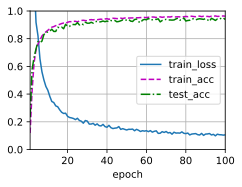

In [11]:
lr = 5e-5
num_epochs = 100
devices = [1, 2, 3]

model = torchvision.models.resnext50_32x4d(weights=ResNeXt50_32X4D_Weights.DEFAULT)
for param in model.parameters():
    param.requires_grad = True
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 512),
    nn.BatchNorm1d(512),
    nn.ReLU(),
    nn.Linear(512, 176)
)
loss_fn = nn.CrossEntropyLoss()
param_1x = [param for name, param in model.named_parameters()
            if name not in {"fc.weight", "fc.bias"}]
optimizer = torch.optim.Adam([
    {'param': param_1x}, {'param': model.fc.parameters(), 'lr': lr * 10}
], lr)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100)

train(model, train_iter, val_iter, loss_fn, optimizer, num_epochs, devices)

In [12]:
# model.block6[2].weight.data

In [14]:
# torch.save(model, "./resnext50_32x4d")

# 推理

In [ ]:
model = torchvision.models.resnext50_32x4d()
model.load_state_dict("./resnext50_32x4d")

In [39]:
def predict(model, test_iter, test_data, devices):
    devices = [d2l.try_gpu(i) for i in devices]
    model.to(devices[0])
    model = nn.DataParallel(model, devices)
    model.eval()
    predicts = []
    with torch.no_grad():
        for X, _ in test_iter:
            X = X.to(devices[0])
            y_hat = model(X)
            y_hat = torch.argmax(y_hat, dim=1).cpu().numpy()
            y_hat = [id2label[idx] for idx in y_hat]
            predicts.extend(y_hat)
    test_data['label'] = pd.Series(predicts)
    submission = pd.concat([test_data['image'], test_data['label']], axis=1)
    submission.to_csv('./submission.csv', index=False)

In [40]:
predict(model, test_iter, test_data, devices)

In [ ]:
# ensemble
def predict(model, test_iter, test_data, devices):
    devices = [d2l.try_gpu(i) for i in devices]
    model.to(devices[0])
    model = nn.DataParallel(model, devices)
    model.eval()
    predicts = []
    with torch.no_grad():
        for X, _ in test_iter:
            X = X.to(devices[0])
            X.premute(1, 0)
            y_hat = torch.zeros((X.shape[0]))
            for X_i in X:
                y_hat += model(X_i)
            y_hat = torch.argmax(y_hat, dim=1).cpu().numpy()
            y_hat = [id2label[idx] for idx in y_hat]
            predicts.extend(y_hat)
    test_data['label'] = pd.Series(predicts)
    submission = pd.concat([test_data['image'], test_data['label']], axis=1)
    submission.to_csv('./submission.csv', index=False)

In [ ]:
predict(model, test_iter, test_data, devices)
